# Longer introduction

Let's explore the methods and attributes available in the ERDDAP object? Note
that we can either use the short server key (NGDAC) or the full URL. For a list
of the short keys check _erddapy.servers_.


In [1]:
from erddapy import ERDDAP

server = "https://gliders.ioos.us/erddap"
e = ERDDAP(server=server)

[method for method in dir(e) if not method.startswith("_")]

['auth',
 'constraints',
 'dataset_id',
 'dim_names',
 'download_file',
 'get_categorize_url',
 'get_download_url',
 'get_info_url',
 'get_search_url',
 'get_var_by_attr',
 'griddap_initialize',
 'protocol',
 'requests_kwargs',
 'response',
 'server',
 'server_functions',
 'to_iris',
 'to_ncCF',
 'to_pandas',
 'to_xarray',
 'variables']

All the methods prefixed with \_get\_\_ will return a valid ERDDAP URL for the
requested response and options. For example, searching for all datasets
available.


In [2]:
url = e.get_search_url(search_for="all", response="html")

print(url)

https://gliders.ioos.us/erddap/search/advanced.html?page=1&itemsPerPage=1000000&protocol=(ANY)&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=(ANY)&variableName=(ANY)&minLon=(ANY)&maxLon=(ANY)&minLat=(ANY)&maxLat=(ANY)&minTime=&maxTime=&searchFor=all


There are many responses available, see the docs for
[griddap](https://erddap.ioos.us/erddap/griddap/documentation.html)
and
[tabledap](https://erddap.ioos.us/erddap/tabledap/documentation.html)
respectively. The most useful ones for Pythonistas are the .csv and .nc that can
be read with pandas and netCDF4-python respectively.

Let's load the csv response directly with pandas.


In [3]:
import pandas as pd

url = e.get_search_url(search_for="whoi", response="csv")

df = pd.read_csv(url)
print(
    f"We have {len(set(df['tabledap'].dropna()))} "
    f"tabledap, {len(set(df['griddap'].dropna()))} "
    f"griddap, and {len(set(df['wms'].dropna()))} wms endpoints.",
)

We have 462 tabledap, 0 griddap, and 0 wms endpoints.


We can refine our search by providing some constraints.

Let's narrow the search area, time span, and look for **sea_water_temperature**.

In [4]:
kw = {
    "standard_name": "sea_water_temperature",
    "min_lon": -72.0,
    "max_lon": -69.0,
    "min_lat": 38.0,
    "max_lat": 41.0,
    "min_time": "2016-07-10T00:00:00Z",
    "max_time": "2017-02-10T00:00:00Z",
    "cdm_data_type": "trajectoryprofile",
}


search_url = e.get_search_url(response="html", **kw)
print(search_url)

https://gliders.ioos.us/erddap/search/advanced.html?page=1&itemsPerPage=1000000&protocol=(ANY)&cdm_data_type=trajectoryprofile&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=sea_water_temperature&variableName=(ANY)&minLon=-72.0&maxLon=-69.0&minLat=38.0&maxLat=41.0&minTime=1468108800.0&maxTime=1486684800.0


The search form was populated with the constraints we provided. Click on the URL above to see how that looks on the server HTML form page.

Changing the response from html to csv we load it in a data frame.

In [5]:
search_url = e.get_search_url(response="csv", **kw)
search = pd.read_csv(search_url)
gliders = search["Dataset ID"].to_numpy()

gliders_list = "\n".join(gliders)
print(f"Found {len(gliders)} Glider Datasets:\n{gliders_list}")

Found 19 Glider Datasets:
blue-20160818T1448
cp_335-20170116T1459-delayed
cp_336-20160809T1354-delayed
cp_336-20161011T0058-delayed
cp_336-20170116T1254-delayed
cp_339-20170116T2353-delayed
cp_340-20160809T0621-delayed
cp_374-20140416T1634-delayed
cp_374-20150509T1256-delayed
cp_374-20160529T0026-delayed
cp_376-20160527T2050-delayed
cp_380-20161011T2046-delayed
cp_387-20160404T1858-delayed
cp_388-20160809T1406-delayed
cp_388-20170116T1324-delayed
cp_389-20161011T2040-delayed
silbo-20160413T1534
sp022-20170209T1616
whoi_406-20160902T1700


Now that we know the Dataset ID we can explore their metadata with the
_get_info_url_ method.


In [6]:
glider = gliders[-1]

info_url = e.get_info_url(dataset_id=glider, response="html")

print(info_url)

https://gliders.ioos.us/erddap/info/whoi_406-20160902T1700/index.html


You can follow the URL above and check this particular dataset_id index page on the server.

We can manipulate the metadata and find the variables that have the
_cdm_profile_variables_ attribute using the csv response.

In [7]:
info_url = e.get_info_url(dataset_id=glider, response="csv")

info = pd.read_csv(info_url)
info.head()

,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,acknowledgment,String,This deployment supported by NOAA through the ...
1,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
2,attribute,NC_GLOBAL,cdm_profile_variables,String,"time_uv,lat_uv,lon_uv,u,v,profile_id,time,lati..."
3,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory,wmo_id"
4,attribute,NC_GLOBAL,comment,String,Glider operatored by Woods Hole Oceanographic ...


In [8]:
"".join(info.loc[info["Attribute Name"] == "cdm_profile_variables", "Value"])

'time_uv,lat_uv,lon_uv,u,v,profile_id,time,latitude,longitude'

Selecting variables by theirs attributes is such a common operation that erddapy
brings its own method to simplify this task.

The _get_var_by_attr_ method was inspired by netCDF4-python's
_get_variables_by_attributes_. However, because erddapy operates on remote
serves, it will return the variable names instead of the actual data.

We ca check what is/are the variable(s) associated with the _standard_name_ used
in the search.

Note that _get_var_by_attr_ caches the last response in case the user needs to
make multiple requests. (See the execution times below.)


In [9]:
%%time

# First request can be slow.
e.get_var_by_attr(
    dataset_id="whoi_406-20160902T1700",
    standard_name="sea_water_temperature",
)

CPU times: user 69.9 ms, sys: 2.32 ms, total: 72.2 ms
Wall time: 252 ms


['temperature']

In [10]:
%%time

# Second request on dataset_id will be faster.
e.get_var_by_attr(
    dataset_id="whoi_406-20160902T1700",
    standard_name="sea_water_practical_salinity",
)

CPU times: user 27 μs, sys: 3 μs, total: 30 μs
Wall time: 33.4 μs


['salinity']

Another way to browse datasets is via the _categorize_ URL. In the example below
we can get all the _standard_names_ available in the dataset with a single
request.


In [11]:
url = e.get_categorize_url(categorize_by="standard_name", response="csv")

pd.read_csv(url)["Category"]

0                                                  _null
1                                 aggregate_quality_flag
2                                               altitude
3                                            backscatter
4                 barotropic_eastward_sea_water_velocity
                             ...                        
136    volume_fraction_of_oxygen_in_sea_water_status_...
137    volume_scattering_coefficient_of_radiative_flu...
138    volume_scattering_function_of_radiative_flux_i...
139                              water_velocity_eastward
140                             water_velocity_northward
Name: Category, Length: 141, dtype: object

We can also pass a **value** to filter the categorize results.


In [12]:
url = e.get_categorize_url(
    categorize_by="institution",
    value="woods_hole_oceanographic_institution",
    response="csv",
)

df = pd.read_csv(url)
whoi_gliders = df.loc[~df["tabledap"].isna(), "Dataset ID"].tolist()
whoi_gliders

['sp007-20170427T1652',
 'sp007-20200618T1527',
 'sp007-20210818T1548',
 'sp007-20220330T1436',
 'sp007-20230208T1524',
 'sp007-20230614T1428',
 'sp007-20240425T1202',
 'sp007-20250418T1600',
 'sp010-20150409T1524',
 'sp010-20170707T1647',
 'sp010-20180620T1455',
 'sp022-20170209T1616',
 'sp022-20170802T1414',
 'sp022-20180124T1514',
 'sp022-20180422T1229',
 'sp022-20180912T1553',
 'sp022-20201113T1549',
 'sp055-20150716T1359',
 'sp062-20171116T1557',
 'sp062-20190201T1350',
 'sp062-20190925T1538',
 'sp062-20200227T1647',
 'sp062-20200824T1618',
 'sp062-20210624T1335',
 'sp062-20211014T1515',
 'sp062-20220623T1419',
 'sp062-20230316T1547',
 'sp062-20230823T1452',
 'sp062-20240410T1536',
 'sp062-20250702T1440',
 'sp065-20151001T1507',
 'sp065-20180310T1828',
 'sp065-20181015T1349',
 'sp065-20190517T1530',
 'sp065-20191120T1543',
 'sp065-20200506T1709',
 'sp065-20210616T1430',
 'sp065-20220202T1520',
 'sp065-20221116T1552',
 'sp065-20230414T1618',
 'sp065-20240214T1520',
 'sp065-20240617

Let's create a map of some WHOI gliders tracks.

We are downloading a lot of data! Note that we will use
[joblib](https://joblib.readthedocs.io/en/latest/) to parallelize the for loop
and get the data faster and we will limit to the first 5 gliders.

In [13]:
import multiprocessing

from joblib import Parallel, delayed

from erddapy.core import get_download_url, to_pandas


def request_whoi(dataset_id):
    variables = ["longitude", "latitude", "temperature", "salinity"]
    url = get_download_url(
        server,
        dataset_id=dataset_id,
        protocol="tabledap",
        variables=variables,
        response="csv",
    )
    # Drop units in the first line and NaNs.
    df = to_pandas(url, pandas_kwargs={"skiprows": (1,)}).dropna()
    return (dataset_id, df)


num_cores = multiprocessing.cpu_count()
downloads = Parallel(n_jobs=num_cores)(
    delayed(request_whoi)(dataset_id) for dataset_id in whoi_gliders[:5]
)

dfs = dict(downloads)

Finally let's see some figures!

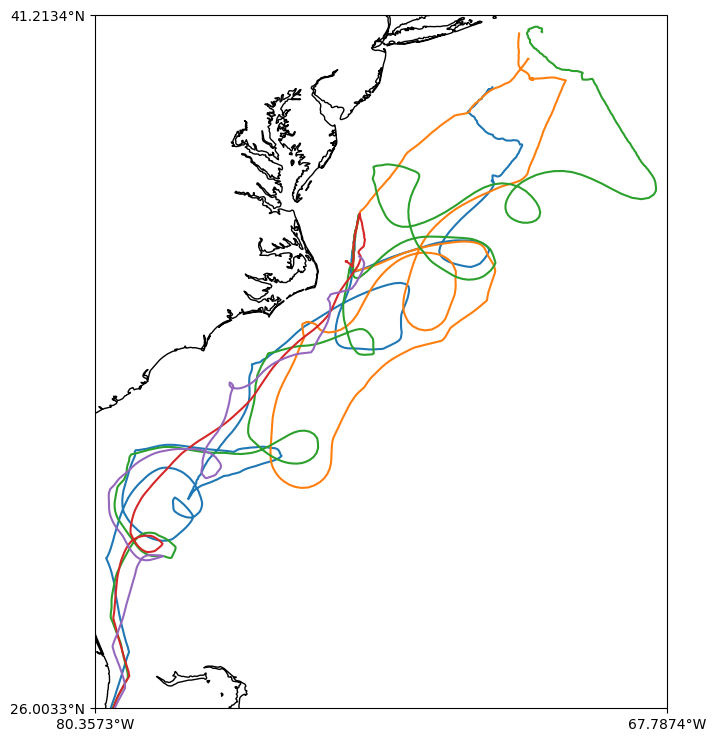

In [14]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter


def make_map():
    fig, ax = plt.subplots(
        figsize=(9, 9),
        subplot_kw={"projection": ccrs.PlateCarree()},
    )
    ax.coastlines(resolution="10m")
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    return fig, ax


fig, ax = make_map()
lons, lats = [], []
for df in dfs.values():
    lon, lat = df["longitude"], df["latitude"]
    lons.extend(lon.array)
    lats.extend(lat.array)
    ax.plot(lon, lat)

dx = dy = 0.25
extent = min(lons) - dx, max(lons) + dx, min(lats) + dy, max(lats) + dy
ax.set_extent(extent)

ax.set_xticks([extent[0], extent[1]], crs=ccrs.PlateCarree())
ax.set_yticks([extent[2], extent[3]], crs=ccrs.PlateCarree());

(np.float64(5.5), np.float64(30.0), np.float64(30.0), np.float64(38.0))

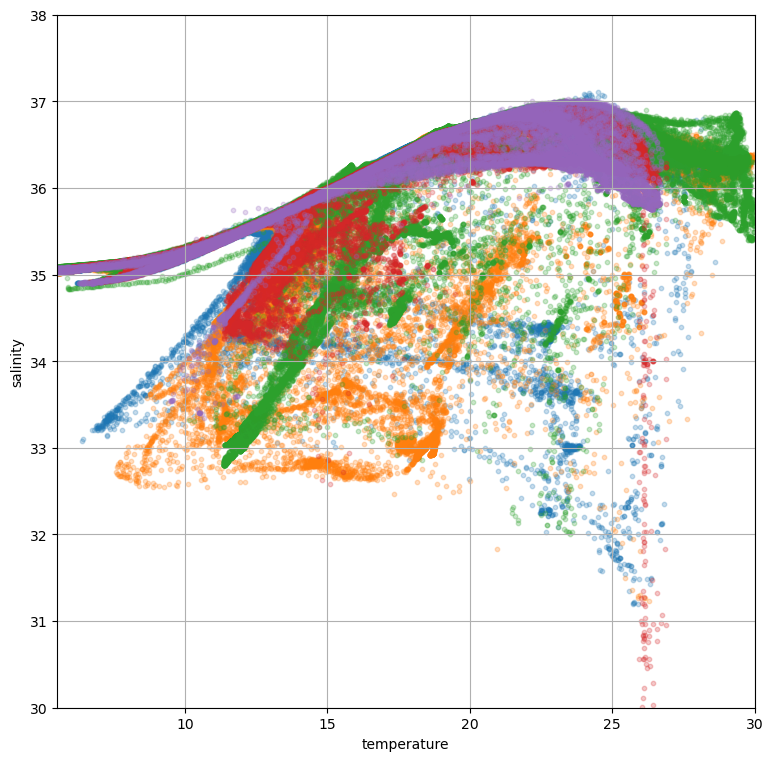

In [15]:
def glider_scatter(df, ax):
    ax.scatter(df["temperature"], df["salinity"], s=10, alpha=0.25)


fig, ax = plt.subplots(figsize=(9, 9))
ax.set_ylabel("salinity")
ax.set_xlabel("temperature")
ax.grid(True)

for df in dfs.values():
    glider_scatter(df, ax)

ax.axis([5.5, 30, 30, 38])

In [16]:
e.dataset_id = "whoi_406-20160902T1700"
e.protocol = "tabledap"
e.variables = [
    "depth",
    "latitude",
    "longitude",
    "salinity",
    "temperature",
    "time",
]

e.constraints = {
    "time>=": "2016-09-03T00:00:00Z",
    "time<=": "2017-02-10T00:00:00Z",
    "latitude>=": 38.0,
    "latitude<=": 41.0,
    "longitude>=": -72.0,
    "longitude<=": -69.0,
}


df = e.to_pandas(
    index_col="time (UTC)",
    parse_dates=True,
).dropna()

Text(0, 0.5, 'Depth (m)')

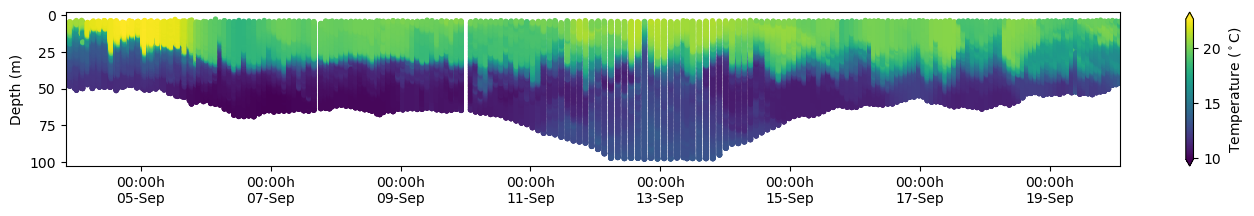

In [17]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(
    df.index,
    df["depth (m)"],
    s=15,
    c=df["temperature (Celsius)"],
    marker="o",
    edgecolor="none",
)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter("%H:%Mh\n%d-%b")
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation="vertical", extend="both")
cbar.ax.set_ylabel(r"Temperature ($^\circ$C)")
ax.set_ylabel("Depth (m)")